In [3]:
#importing the neccessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
# Simulating the time series data
np.random.seed(42)
timesteps = 1000
features = 5

# Generating the time-dependent features
dates = pd.date_range(start='2020-01-01', periods=timesteps, freq='D')
X = np.array([np.sin(0.1 * np.arange(timesteps) + np.random.rand()) for _ in range(features)]).T
noise = np.random.randn(timesteps) * 0.1

# Generating a target variable with some dependency on features
y = 0.1 * X[:, 0] + 0.2 * X[:, 1] + 0.3 * X[:, 2] + noise

# Create a DataFrame with dates as the index
# Create a DataFrame with days of the week as feature names
df = pd.DataFrame(X, columns=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], index=dates)
df['Target'] = y

In [24]:
# Checking for a portion of the data
df.head()

,Monday,Tuesday,Wednesday,Thursday,Friday,Target
2020-01-01,0.365845,0.813831,0.668354,0.563535,0.155386,0.427761
2020-01-02,0.456929,0.867778,0.739276,0.643191,0.253231,0.542083
2020-01-03,0.543449,0.913055,0.802810,0.716421,0.348545,0.419711
2020-01-04,0.624538,0.949210,0.858324,0.782492,0.440377,0.457276
2020-01-05,0.699387,0.975880,0.905261,0.840745,0.527809,0.479555


In [25]:
df.shape

(1000, 6)

In [26]:
# Calculate the split index for 80% training and 20% testing
split_index = int(timesteps * 0.8)

# Split the data into training and testing sets
train_df = df.iloc[:split_index] 
test_df = df.iloc[split_index:] 

# Separate the features and the target variable for training and testing
X_train = train_df.drop(columns=['Target']).values  
y_train = train_df['Target'].values  
X_test = test_df.drop(columns=['Target']).values 
y_test = test_df['Target'].values 

# Reshape the input data to 3D for the LSTM model (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))  

In [27]:
# Scale the features to have mean 0 and variance 1
scaler = StandardScaler()  
X_train = scaler.fit_transform(X_train.reshape(-1, features)).reshape(-1, 1, features)  
X_test = scaler.transform(X_test.reshape(-1, features)).reshape(-1, 1, features)  

In [28]:
def create_lstm_model():
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [44]:
# Create the model
model_without_es = create_lstm_model()

# Train the model without Early Stopping
history_without_es = model_without_es.fit(X_train, y_train,
                                          validation_data=(X_test, y_test),
                                          epochs=100,
                                          batch_size=32,
                                          verbose=0)

C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


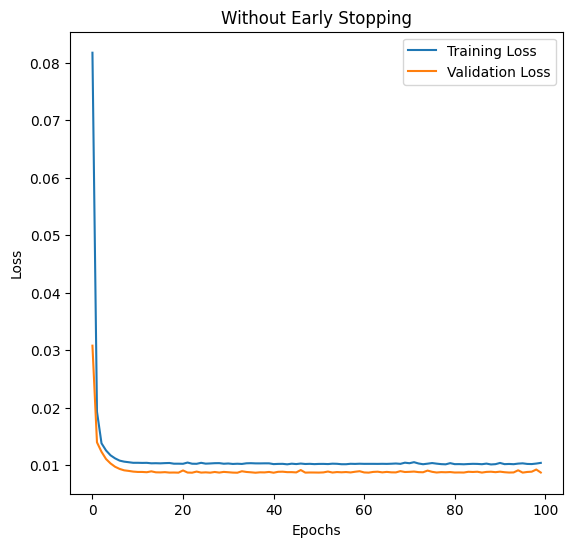

In [45]:
plt.figure(figsize=(14, 6))

# Without Early Stopping
plt.subplot(1, 2, 1)
plt.plot(history_without_es.history['loss'], label='Training Loss')
plt.plot(history_without_es.history['val_loss'], label='Validation Loss')
plt.title('Without Early Stopping')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [46]:
y_pred_without_es = model_without_es.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


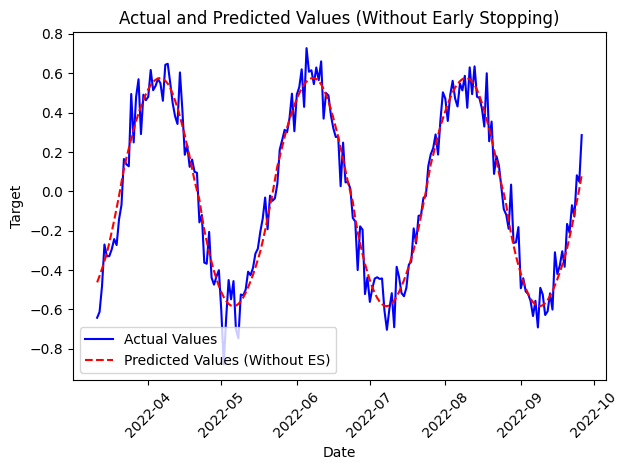

In [47]:
# Plot actual vs. predicted values without Early Stopping
plt.plot(test_df.index, y_test, label='Actual Values', color='blue')  
plt.plot(test_df.index, y_pred_without_es, label='Predicted Values (Without ES)', color='red', linestyle='--')  

plt.title('Actual and Predicted Values (Without Early Stopping)')  
plt.xlabel('Date')  
plt.xticks(rotation=45)  
plt.ylabel('Target')  
plt.legend()  
plt.tight_layout()  
plt.show()  

In [54]:
# Calculate metrics for the model without Early Stopping
mse_without_es = mean_squared_error(y_test, y_pred_without_es)
rmse_without_es = np.sqrt(mse_without_es)
mae_without_es = mean_absolute_error(y_test, y_pred_without_es)

# Print the results
print("Model Without Early Stopping:")
print(f"MSE: {mse_without_es:.4f}")
print(f"RMSE: {rmse_without_es:.4f}")
print(f"MAE: {mae_without_es:.4f}")

Model Without Early Stopping:
MSE: 0.0088
RMSE: 0.0935
MAE: 0.0745


In [55]:
# Create the model
model_with_es = create_lstm_model()

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with Early Stopping
history_with_es = model_with_es.fit(X_train, y_train,
                                    validation_data=(X_test, y_test),
                                    epochs=100,
                                    batch_size=32,
                                    callbacks=[early_stopping],
                                    verbose=0)

C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


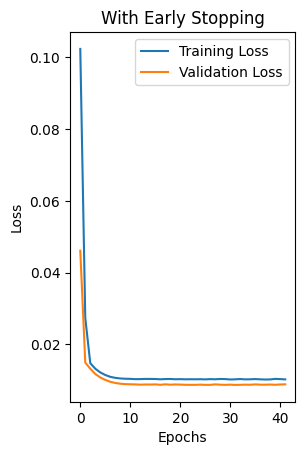

In [56]:
# With Early Stopping
plt.subplot(1, 2, 2)
plt.plot(history_with_es.history['loss'], label='Training Loss')
plt.plot(history_with_es.history['val_loss'], label='Validation Loss')
plt.title('With Early Stopping')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [57]:
# Predictions for both models
y_pred_with_es = model_with_es.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


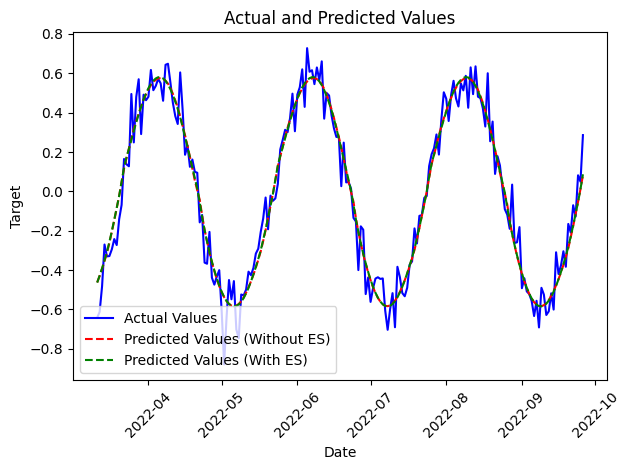

In [58]:
# Plot actual vs predicted for both models
plt.plot(test_df.index, y_test, label='Actual Values', color='blue')  
plt.plot(test_df.index, y_pred_without_es, label='Predicted Values (Without ES)', color='red', linestyle='--')  
plt.plot(test_df.index, y_pred_with_es, label='Predicted Values (With ES)', color='green', linestyle='--')  

plt.title('Actual and Predicted Values')  
plt.xlabel('Date')  
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.ylabel('Target')  
plt.legend()  

plt.tight_layout()  
plt.show()  

In [59]:
# Calculate metrics for the model without Early Stopping
mse_without_es = mean_squared_error(y_test, y_pred_without_es)
rmse_without_es = np.sqrt(mse_without_es)
mae_without_es = mean_absolute_error(y_test, y_pred_without_es)

# Calculate metrics for the model with Early Stopping
mse_with_es = mean_squared_error(y_test, y_pred_with_es)
rmse_with_es = np.sqrt(mse_with_es)
mae_with_es = mean_absolute_error(y_test, y_pred_with_es)

# Print the results
print("Model Without Early Stopping:")
print(f"MSE: {mse_without_es:.4f}")
print(f"RMSE: {rmse_without_es:.4f}")
print(f"MAE: {mae_without_es:.4f}")

print("\nModel With Early Stopping:")
print(f"MSE: {mse_with_es:.4f}")
print(f"RMSE: {rmse_with_es:.4f}")
print(f"MAE: {mae_with_es:.4f}")

Model Without Early Stopping:
MSE: 0.0088
RMSE: 0.0935
MAE: 0.0745

Model With Early Stopping:
MSE: 0.0087
RMSE: 0.0933
MAE: 0.0743
